<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_Kaggle/blob/main/20221016_porto_driver_Missingno_globals_state-based-subplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 안전 운전자 예측
 - 고객 데이터 활용하여, 운전자가 보험을 청구할 확률 예측
 - 문제유형 : 이진분류
 - 평가지표 : 정규화된 지니계수
 - 사용모델 : LightGBM와 XGBoost의 앙상블

In [40]:
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/porto-seguro-safe-driver-prediction/'
train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [41]:
train.shape, test.shape

((595212, 58), (892816, 57))

In [42]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [43]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


 - 타깃값 확률이 일괄 0.0364
 - 타깃값이 1(보험금을 청구)일 확률을 예측하는 것이 목표
 - 즉, 운전자가 보험금을 청구할 확률이 얼마나 되는지를 예측해야 함

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

 - 모든 피처가 결측값이 non-null : 주의
 - 값이 누락된 곳에 -1이 입력되어 있어서 결측값이 없다고 판단한 것

  > -1을 np.NaN으로 변환한 다음 개수 파악

 - 결측값을 시각화해서 보여주는 missingno 패키지의 bar()함수 or matrix()함수 사용

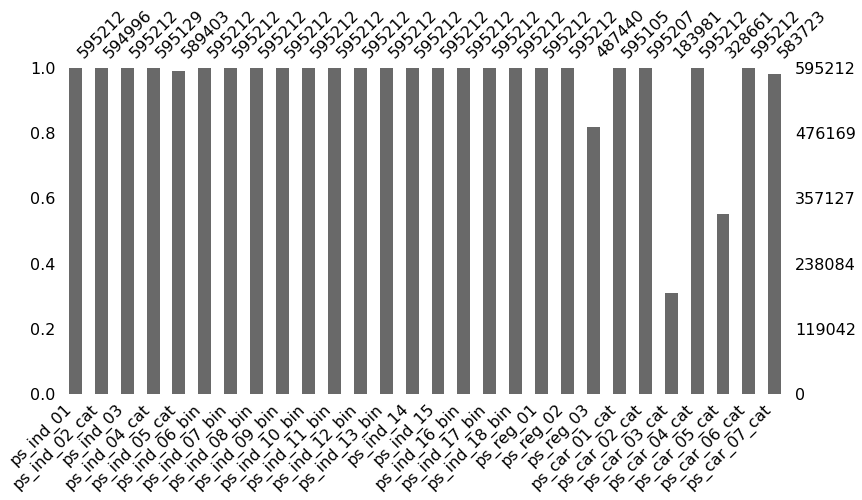

In [45]:
import numpy as np
import missingno as msno

# 훈련 데이터 복사본에서 -1을 np.NaN로 변환
train_copy = train.copy().replace(-1, np.NaN) # train 데이터는 향후 다른 시각화도 해야하기 때문에 복사 후 사용

# 결측값 시각화(처음 28개만)
msno.bar(df=train_copy.iloc[:, 1:29], figsize=(13, 6))

 - 그래프가 낮을수록 결측값이 많다
 - 상단의 숫자는 정상 값의 개수

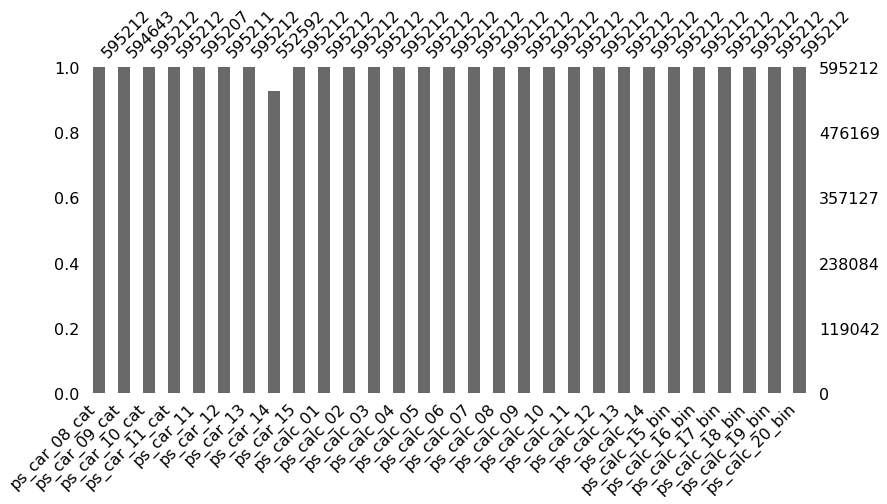

In [46]:
msno.bar(df=train_copy.iloc[:, 29:], figsize=(13, 6))

In [47]:
def resumetable(df):
    print(f'데이터 형상: {df.shape}')

    global summary # 전역변수 지정을 해줘야 전역변수로 사용가능함 : 함수의 실행(변수 지정 없이)만으로 summary변수가 생김

    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입']) # DataFrame : index가 컬럼명들이고, 각 데이터는 dtypes
    summary['결측값 개수'] = (df==-1).sum().values # DataFrame에 '결측값 개수'컬럼 추가
    summary['고윳값 개수'] = df.nunique().values # DataFrame에 '고윳값 개수'컬럼 추가
    summary['데이터 종류'] = None # DataFrame에 '데이터 종류'컬럼 추가(초기화 상태)
    for col in df.columns:
        if 'bin' in col or col == 'target': # if 조건문에 두가지 조건
            summary.loc[col, '데이터 종류'] = '이진형' # df.loc[index/조건, '컬럼명'] = 값 : 조건에 해당하는 지정된 컬럼의 값을 변경
        elif 'cat' in col:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif df[col].dtype == int:
            summary.loc[col, '데이터 종류'] = '순서형'
    

    return summary



```
(df == -1).sum().values
```
df의 -1값들을 피처(컬럼)별로 개수를 더한 배열 생성


In [48]:
resumetable(train) # 함수실행만으로 summary라는 변수명이 전역변수로 나오게 되네?

# summary = resumetable(train) # 함수내에서 전역변수 지정하지 않을시 이렇게 사용해줘야 변수로써 활용가능 함

데이터 형상: (595212, 58)


,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [49]:
# 피처 요약표 활용
summary[summary['데이터 타입'] == 'float64'].index # summary가 전역변수로 지정되지 않아서 오류를 표시하면서도 사용은 가능하네?...

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object')

[함수내 변수 전역변수 지정](https://ddanggle.gitbooks.io/interpy-kr/content/ch8-Global-Return.html)

In [50]:
# 심지어 전역변수가 있다고 표현됨
if 'summary' in globals():
    print('있음')
else:
    print('없음')

있음


### 데이터 시각화
 - 타깃값 분포를 활용해 타깃값이 얼마나 불균형한지 확인
 - 이진/명목형/순서형 피처의 고윳값별 타깃값 비율 확인

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

#### 타깃값 분포

In [52]:
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 그래프 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height() # 도형 높이(데이터 개수)
        width = patch.get_width()   # 도형 너비
        left_coord = patch.get_x()  # 도형 왼쪽 테두리의 x축 위치
        percent = height/total_size*100 # 타깃값 비율

        # (x, y) 좌표에 텍스트 입력
        ax.text(x=left_coord + width/2.0, # x축 위치
                y=height + total_size*0.001,  # y축 위치
                s=f'{percent:1.1f}%',
                ha='center')

Text(0.5, 1.0, 'Target Distribution')

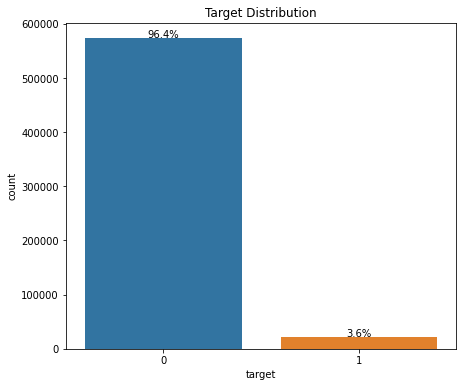

In [53]:
plt.figure(figsize=(7, 6))
# State-Based(↔Object-Oriented)
ax = sns.countplot(x='target', data=train) # return AxesSubplot : axes-level function 
write_percent(ax, len(train)) # 비율 표시
ax.set_title('Target Distribution')

[matplotlib subplot vs subplots 완벽정리](https://blog.naver.com/rising_n_falling/222467744170)

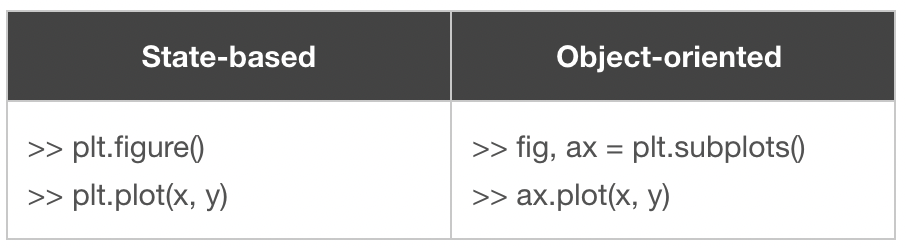

 - State-based 방식으로는 최근에 생성한 subplot만 그래프의 설정을 변경할 수 있음(과거의 subplot설정 변경 불가)
 - plt.figure()로 시작한 경우에도 axes객체를 생성하고 변수를 지정해주면 Object-oriented방식으로 사용가능

 - 고윳값 별 타깃값 1의 비율 확인 → 해당 피처가 모델링에 필요한 피처인지 확인

  > 고윳값 마다 타깃값 비율이 다른 피처여야 모델링에 도움됨

  > 신뢰구간이 크면 통계적 유효성이 떨어짐

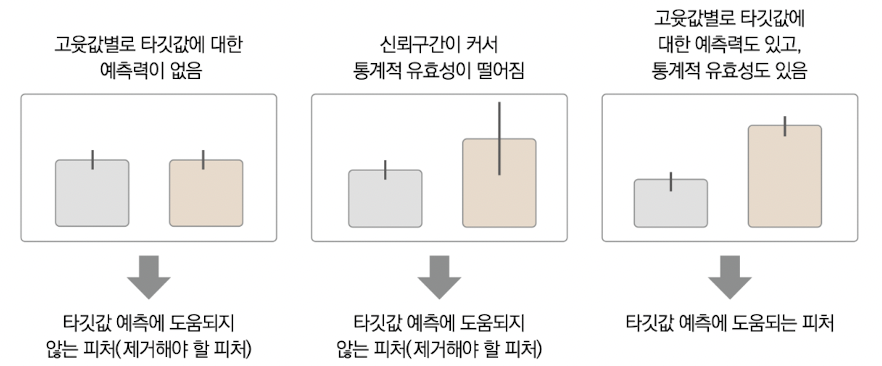

#### 이진 피처
 - 고윳값별 타깃값 비율을 막대그래프로

In [54]:
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols,
                                  size=(12, 18)):
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows, num_cols) # 그리드스펙 객체생성 : 축으로 구성된 리스트
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # t서브플롯 좌우/상하 여백 설정

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx]) # ax = plt.subplot(GridSpec[idx]) : 그리드스펙 활용을 위해 축을 할당
        sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)

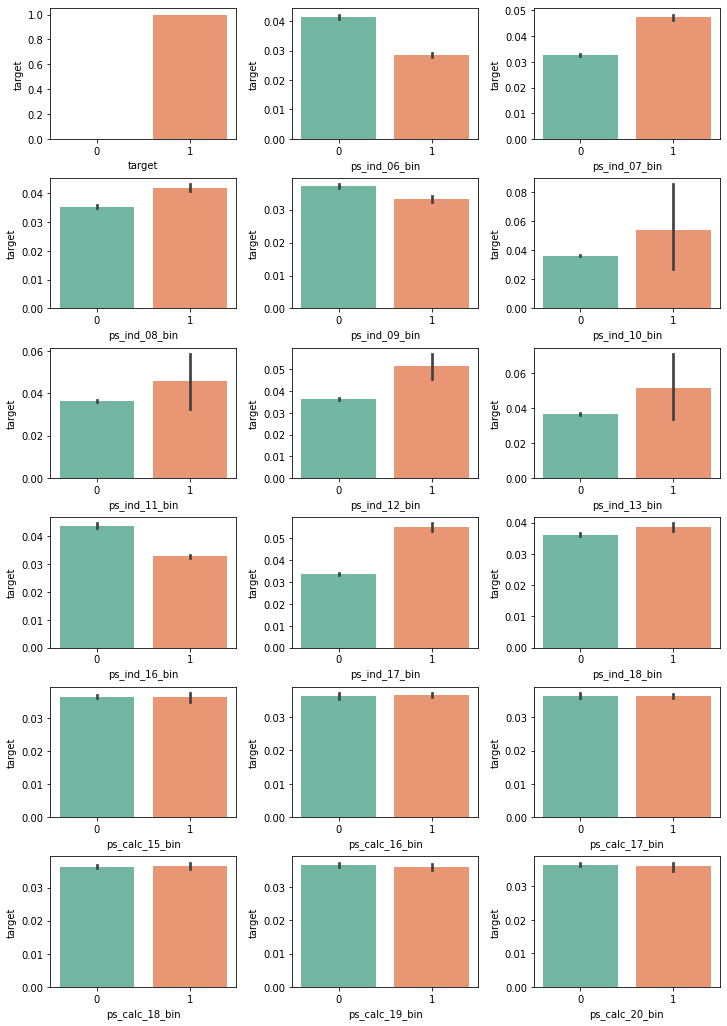

In [55]:
bin_features = summary[summary['데이터 종류'] == '이진형'].index # 이진 피처명들의 리스트

# 이진 피처 고윳값별 타깃값 1의 비율을 막대 그래프로 그리기
plot_target_ratio_by_features(train, bin_features, 6, 3) # 6행 3열

In [56]:
summary.columns

Index(['데이터 타입', '결측값 개수', '고윳값 개수', '데이터 종류'], dtype='object')